# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
data_snp = pd.read_csv("C:/Users/bciez/Documents/Basilio/Columbia_University/MLdosage/ADC_CH_MEX/SNP_coding_chr1_dominant.csv")  # Replace with your full merged dataset if needed
print(data_snp.shape)
data_snp.head()


(1143, 13)


,chr5:172285127:A:T_T,chr5:172285929:G:T_T,chr5:172287089:G:A_A,chr10:62188210:T:C_C,chr19:44887076:A:G_G,chr19:44892457:T:C_C,chr19:44892962:C:T_T,chr19:44906745:G:A_A,chr19:44908684:T:C_C,chr19:44912456:G:A_A,chr19:44912678:G:T_T,chr19:44912921:G:T_T,chr19:44913484:C:T_T
0,0,0,0,0,1,1,1,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,1,1,1,1,1
2,1,1,0,1,1,1,1,0,1,0,0,1,1
3,0,0,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,1,1,1,0,0,0,0,0,0


In [3]:
# === Load preselected SNP data === #
data_pheno = pd.read_csv("C:/Users/bciez/Documents/Basilio/Columbia_University/MLdosage/ADC_CH_MEX/pheno_with_pcs.txt",sep="\t")  # Replace with your full merged dataset if needed
print(data_pheno.shape)
data_pheno.head()

(1143, 21)


,FID,IID,AGE,SEX,APOEe4,ADRD,PC1,PC2,PC3,PC4,...,PC1.1,PC2.1,PC3.1,PC4.1,PC5.1,PC6,PC7,PC8,PC9,PC10
0,0,NACC000618,NaN,1,0.0,1.0,0.044661,0.025408,0.004511,0.031928,...,0.044661,0.025408,0.004511,0.031928,0.011477,-0.037766,0.035148,0.038340,0.023576,0.010447
1,0,NACC001006,64.0,2,1.0,0.0,0.014449,-0.045978,-0.013300,-0.034999,...,0.014449,-0.045978,-0.013300,-0.034999,0.014755,-0.014482,-0.003970,0.015603,0.015387,-0.001958
2,0,NACC001999,92.0,1,1.0,1.0,0.082365,0.087493,0.002627,-0.002423,...,0.082365,0.087493,0.002627,-0.002423,-0.015638,0.027654,0.008558,0.004272,0.031828,0.003412
3,0,NACC003295,81.0,2,1.0,1.0,-0.024469,0.011454,0.000153,0.020190,...,-0.024469,0.011454,0.000153,0.020190,-0.057066,-0.023184,0.072774,0.019575,-0.010191,0.032738
4,0,NACC003515,72.0,1,0.0,0.0,-0.021727,-0.002144,-0.013821,0.012050,...,-0.021727,-0.002144,-0.013821,0.012050,-0.007025,-0.004897,0.023285,0.004250,0.032591,-0.038017


In [4]:
data = pd.concat([data_pheno, data_snp], axis=1)
data

,FID,IID,AGE,SEX,APOEe4,ADRD,PC1,PC2,PC3,PC4,...,chr10:62188210:T:C_C,chr19:44887076:A:G_G,chr19:44892457:T:C_C,chr19:44892962:C:T_T,chr19:44906745:G:A_A,chr19:44908684:T:C_C,chr19:44912456:G:A_A,chr19:44912678:G:T_T,chr19:44912921:G:T_T,chr19:44913484:C:T_T
0,0,NACC000618,NaN,1,0.0,1.0,0.044661,0.025408,0.004511,0.031928,...,0,1,1,1,0,0,0,0,0,0
1,0,NACC001006,64.0,2,1.0,0.0,0.014449,-0.045978,-0.013300,-0.034999,...,0,1,1,1,1,1,1,1,1,1
2,0,NACC001999,92.0,1,1.0,1.0,0.082365,0.087493,0.002627,-0.002423,...,1,1,1,1,0,1,0,0,1,1
3,0,NACC003295,81.0,2,1.0,1.0,-0.024469,0.011454,0.000153,0.020190,...,0,1,1,1,1,1,1,1,1,1
4,0,NACC003515,72.0,1,0.0,0.0,-0.021727,-0.002144,-0.013821,0.012050,...,0,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,NACC996241,61.0,2,0.0,0.0,-0.015915,-0.012894,-0.009881,-0.020986,...,0,0,0,0,0,0,0,0,0,0
1139,0,NACC997010,81.0,2,0.0,0.0,0.003713,-0.017111,0.000210,0.045111,...,0,1,1,1,0,0,0,0,0,0
1140,0,NACC997136,75.0,2,0.0,1.0,0.012023,-0.024965,-0.031376,-0.012753,...,1,0,0,0,0,0,0,0,0,0
1141,0,NACC999529,93.0,2,0.0,0.0,-0.023041,0.003206,0.033446,-0.002028,...,1,1,1,1,0,0,0,0,0,0


In [5]:
print(data.shape)

(1143, 34)


In [6]:
data.columns.to_list()[0:30]

['FID',
 'IID',
 'AGE',
 'SEX',
 'APOEe4',
 'ADRD',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC1.1',
 'PC2.1',
 'PC3.1',
 'PC4.1',
 'PC5.1',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'chr5:172285127:A:T_T',
 'chr5:172285929:G:T_T',
 'chr5:172287089:G:A_A',
 'chr10:62188210:T:C_C',
 'chr19:44887076:A:G_G',
 'chr19:44892457:T:C_C',
 'chr19:44892962:C:T_T',
 'chr19:44906745:G:A_A',
 'chr19:44908684:T:C_C']

In [7]:
#data['Ethnicity'].value_counts()

In [8]:
#data = data[data['Ethnicity'] == 0]
#print(data.shape)
df_filtered = data[data['ADRD'].notna()]
data = df_filtered.copy()
print(data.shape)
data.head()

(928, 34)


,FID,IID,AGE,SEX,APOEe4,ADRD,PC1,PC2,PC3,PC4,...,chr10:62188210:T:C_C,chr19:44887076:A:G_G,chr19:44892457:T:C_C,chr19:44892962:C:T_T,chr19:44906745:G:A_A,chr19:44908684:T:C_C,chr19:44912456:G:A_A,chr19:44912678:G:T_T,chr19:44912921:G:T_T,chr19:44913484:C:T_T
0,0,NACC000618,NaN,1,0.0,1.0,0.044661,0.025408,0.004511,0.031928,...,0,1,1,1,0,0,0,0,0,0
1,0,NACC001006,64.0,2,1.0,0.0,0.014449,-0.045978,-0.013300,-0.034999,...,0,1,1,1,1,1,1,1,1,1
2,0,NACC001999,92.0,1,1.0,1.0,0.082365,0.087493,0.002627,-0.002423,...,1,1,1,1,0,1,0,0,1,1
3,0,NACC003295,81.0,2,1.0,1.0,-0.024469,0.011454,0.000153,0.020190,...,0,1,1,1,1,1,1,1,1,1
4,0,NACC003515,72.0,1,0.0,0.0,-0.021727,-0.002144,-0.013821,0.012050,...,0,1,1,1,0,0,0,0,0,0


In [9]:
data.columns

Index(['FID', 'IID', 'AGE', 'SEX', 'APOEe4', 'ADRD', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC1.1', 'PC2.1', 'PC3.1', 'PC4.1', 'PC5.1', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'chr5:172285127:A:T_T', 'chr5:172285929:G:T_T',
       'chr5:172287089:G:A_A', 'chr10:62188210:T:C_C', 'chr19:44887076:A:G_G',
       'chr19:44892457:T:C_C', 'chr19:44892962:C:T_T', 'chr19:44906745:G:A_A',
       'chr19:44908684:T:C_C', 'chr19:44912456:G:A_A', 'chr19:44912678:G:T_T',
       'chr19:44912921:G:T_T', 'chr19:44913484:C:T_T'],
      dtype='object')

In [10]:


X = data.drop(columns=['FID', 'IID', 'AGE', 'SEX', 'APOEe4', 'ADRD', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC1.1', 'PC2.1', 'PC3.1', 'PC4.1', 'PC5.1', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10'])  # Replace 'ADRD_FINAL' with your phenotype column
y = data["ADRD"]


In [11]:
X.head(20)

,chr5:172285127:A:T_T,chr5:172285929:G:T_T,chr5:172287089:G:A_A,chr10:62188210:T:C_C,chr19:44887076:A:G_G,chr19:44892457:T:C_C,chr19:44892962:C:T_T,chr19:44906745:G:A_A,chr19:44908684:T:C_C,chr19:44912456:G:A_A,chr19:44912678:G:T_T,chr19:44912921:G:T_T,chr19:44913484:C:T_T
0,0,0,0,0,1,1,1,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,1,1,1,1,1
2,1,1,0,1,1,1,1,0,1,0,0,1,1
3,0,0,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,1,1,1,0,0,0,0,0,0
6,0,0,0,1,1,1,1,0,0,0,0,1,1
8,1,1,1,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,1,1,1,1,1,1,1,1,1
10,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,1,0,0,0,0,0,0,0,0


In [12]:
y.head()

0    1.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: ADRD, dtype: float64

In [13]:
print(y.value_counts())


ADRD
1.0    475
0.0    453
Name: count, dtype: int64


In [14]:
y

0       1.0
1       0.0
2       1.0
3       1.0
4       0.0
       ... 
1138    0.0
1139    0.0
1140    1.0
1141    0.0
1142    0.0
Name: ADRD, Length: 928, dtype: float64

# Split data

In [15]:
# Check for NaNs or infinite values
print("NaNs in X:", X.isnull().sum().sum())
print("NaNs in y:", y.isnull().sum())
print("Infinite values in X:", np.isinf(X).sum().sum())

# Check again
print("After cleaning - NaNs in X:", X.isnull().sum().sum())
print("After cleaning - NaNs in y:", y.isnull().sum())


NaNs in X: 0
NaNs in y: 0
Infinite values in X: 0
After cleaning - NaNs in X: 0
After cleaning - NaNs in y: 0


In [16]:
columns_no_nan = X.columns[X.notna().all()]
len(columns_no_nan)
len(X.columns.to_list())

13

In [17]:
print(X.shape)
X_temp = X[columns_no_nan]
X = X_temp.copy()
print(X.shape)

(928, 13)
(928, 13)


In [18]:
#data_clean = data.dropna()
#data = data_clean.copy()
# Sanitize column names
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

In [19]:
# === Split data === #
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


In [20]:
X_train

,chr5_172285127_A_T_T,chr5_172285929_G_T_T,chr5_172287089_G_A_A,chr10_62188210_T_C_C,chr19_44887076_A_G_G,chr19_44892457_T_C_C,chr19_44892962_C_T_T,chr19_44906745_G_A_A,chr19_44908684_T_C_C,chr19_44912456_G_A_A,chr19_44912678_G_T_T,chr19_44912921_G_T_T,chr19_44913484_C_T_T
1019,0,0,0,0,0,0,0,0,0,0,0,0,0
862,0,0,0,0,1,1,1,1,1,1,1,1,1
40,0,0,0,0,0,0,0,0,0,0,0,0,0
750,0,0,0,1,1,1,1,0,1,0,0,1,1
998,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,0,0,0,0,1,1,1,0,0,0,0,0,0
15,0,0,0,0,1,1,1,1,1,1,1,1,1
1043,0,0,0,0,0,0,0,0,0,0,0,0,0
354,0,0,0,0,1,1,1,0,0,0,0,0,0


# Logistic Regression Models

In [21]:
# === Define models and hyperparameter grids === #
param_distributions = {
    "Logistic_Lasso": {
        "model": LogisticRegression(solver='saga', max_iter=1000),
        "params": {"C": np.logspace(-4, 2, 10), "penalty": ["l1"]}
    },
    "Logistic_Ridge": {
        "model": LogisticRegression(solver='saga', max_iter=1000),
        "params": {"C": np.logspace(-4, 2, 10), "penalty": ["l2"]}
    },
    "Logistic_ElasticNet": {
        "model": LogisticRegression(solver='saga', max_iter=1000, l1_ratio=0.5),
        "params": {"C": np.logspace(-4, 2, 10), "penalty": ["elasticnet"], "l1_ratio": [0.1, 0.5, 0.9]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 6, 9]}
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "num_leaves": [20, 31, 40]}
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {"depth": [4, 6, 8], "learning_rate": [0.01, 0.1, 0.2], "iterations": [100, 200, 300]}
    },
    "NeuralNetwork": {
        "model": MLPClassifier(max_iter=500),
        "params": {"hidden_layer_sizes": [(50,), (100,), (100, 50)], "alpha": np.logspace(-4, 1, 5)}
    }
}



🔎 Performing randomized search for Logistic_Lasso...


✅ Best hyperparameters for Logistic_Lasso: {'penalty': 'l1', 'C': 0.21544346900318823}


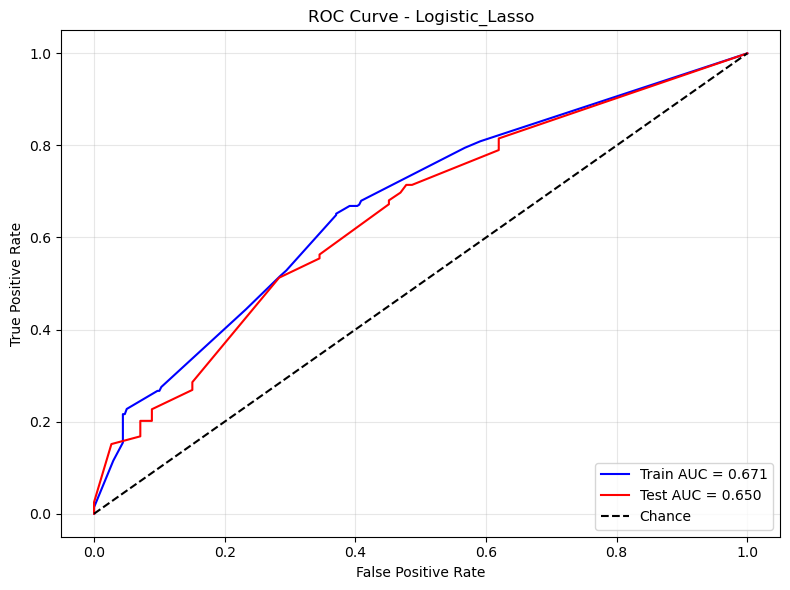

📊 Logistic_Lasso - Train AUC: 0.6711 | Test AUC: 0.6499

🔎 Performing randomized search for Logistic_Ridge...
✅ Best hyperparameters for Logistic_Ridge: {'penalty': 'l2', 'C': 0.046415888336127774}


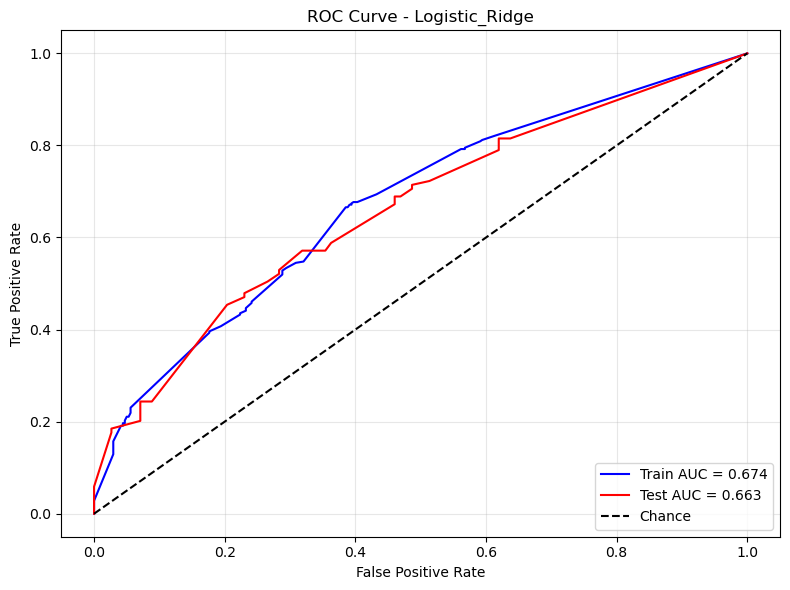

📊 Logistic_Ridge - Train AUC: 0.6739 | Test AUC: 0.6626

🔎 Performing randomized search for Logistic_ElasticNet...
✅ Best hyperparameters for Logistic_ElasticNet: {'penalty': 'elasticnet', 'l1_ratio': 0.1, 'C': 0.046415888336127774}


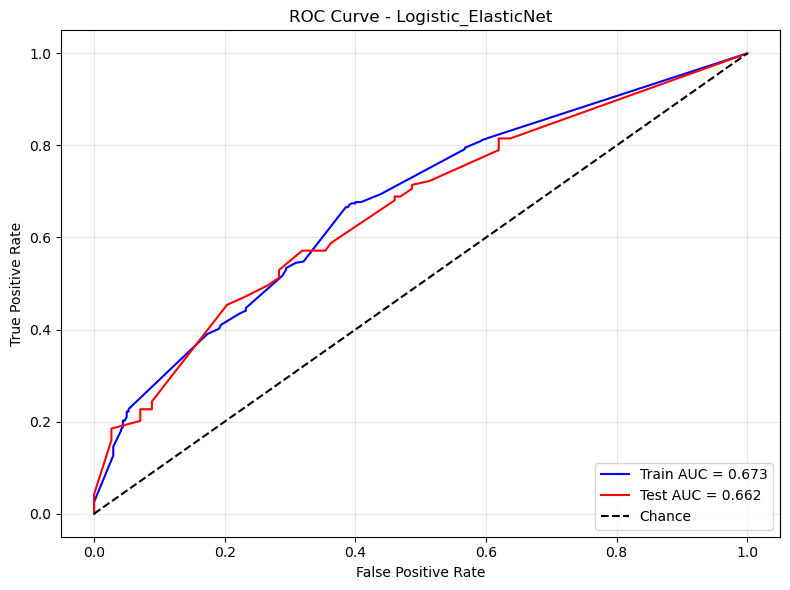

📊 Logistic_ElasticNet - Train AUC: 0.6731 | Test AUC: 0.6618

🔎 Performing randomized search for XGBoost...
✅ Best hyperparameters for XGBoost: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}


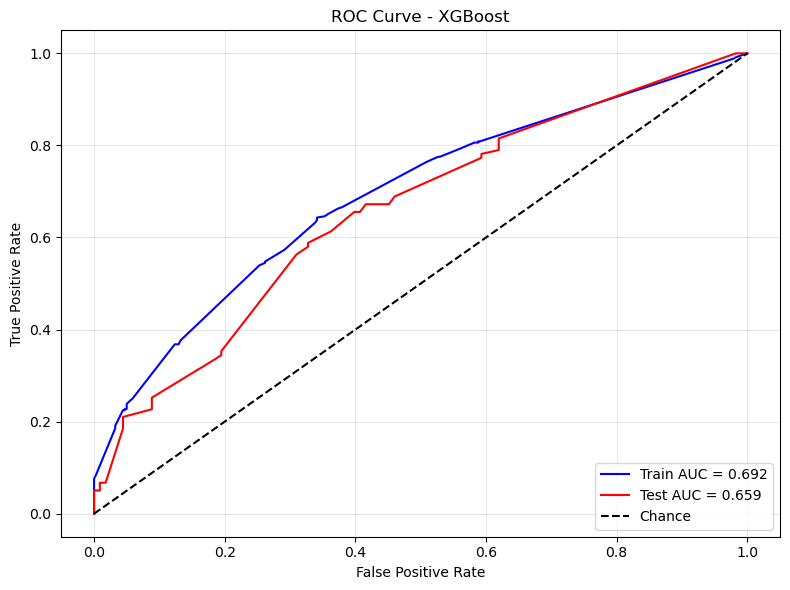

📊 XGBoost - Train AUC: 0.6919 | Test AUC: 0.6586

🔎 Performing randomized search for LightGBM...
[LightGBM] [Info] Number of positive: 356, number of negative: 340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 696, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511494 -> initscore=0.045985
[LightGBM] [Info] Start training from score 0.045985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

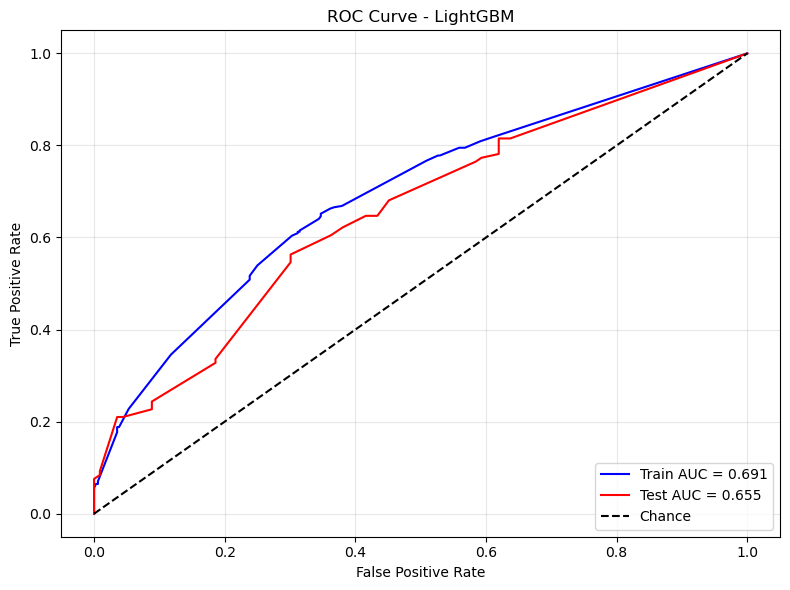

📊 LightGBM - Train AUC: 0.6907 | Test AUC: 0.6546

🔎 Performing randomized search for CatBoost...
✅ Best hyperparameters for CatBoost: {'learning_rate': 0.01, 'iterations': 100, 'depth': 4}


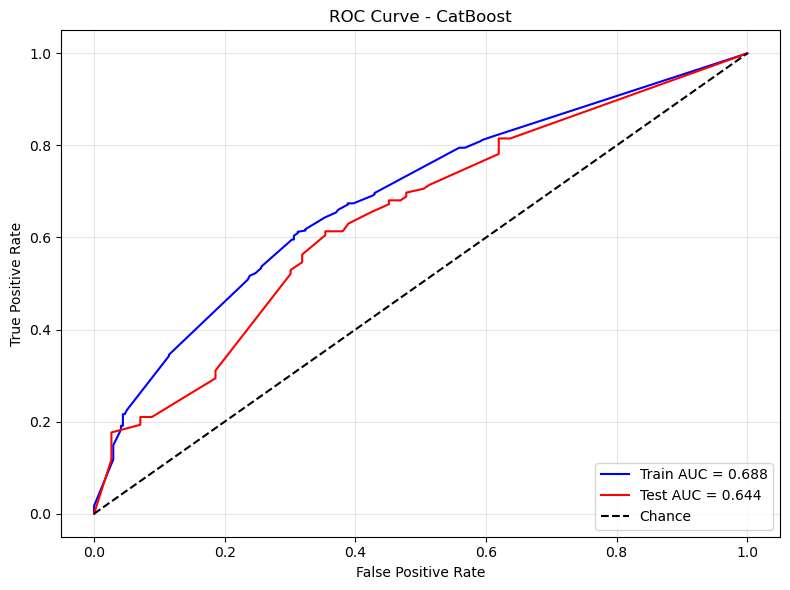

📊 CatBoost - Train AUC: 0.6879 | Test AUC: 0.6444

🔎 Performing randomized search for NeuralNetwork...
✅ Best hyperparameters for NeuralNetwork: {'hidden_layer_sizes': (50,), 'alpha': 0.5623413251903491}


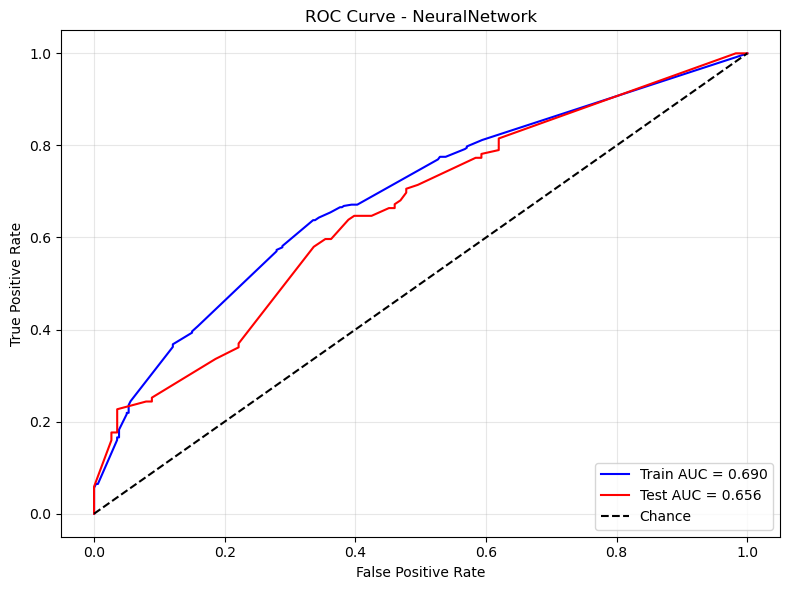

📊 NeuralNetwork - Train AUC: 0.6895 | Test AUC: 0.6560


In [22]:
# === Cross-validation setup === #
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# === Train, evaluate, and plot ROC curves === #
for name, config in param_distributions.items():
    print(f"\n🔎 Performing randomized search for {name}...")

    # Randomized hyperparameter search
    random_search = RandomizedSearchCV(
        config["model"], config["params"], cv=cv, scoring='roc_auc', n_iter=10, random_state=42, n_jobs=4
    )
    
    random_search.fit(X_train, y_train)  # Cross-validation on training set
    best_model = random_search.best_estimator_  # Select best model from CV
    
    print(f"✅ Best hyperparameters for {name}: {random_search.best_params_}")

    # Predict probabilities using the best model
    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict_proba(X_test)[:, 1]

    # AUC scores
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", color='blue')
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", color='red')
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"../output/plots/ROC_{name}_CHsumStat_PRADIdosage_dominant_ADSP.png")
    plt.show()

    print(f"📊 {name} - Train AUC: {auc_train:.4f} | Test AUC: {auc_test:.4f}")

# Fitting

In [23]:
print(y_train.value_counts())


ADRD
1.0    356
0.0    340
Name: count, dtype: int64


# Evaluation of feature importance


🔎 Evaluating Logistic_Lasso with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6581 ± 0.0170
📊 Logistic_Lasso - Train AUC: 0.6711 | Test AUC: 0.6499


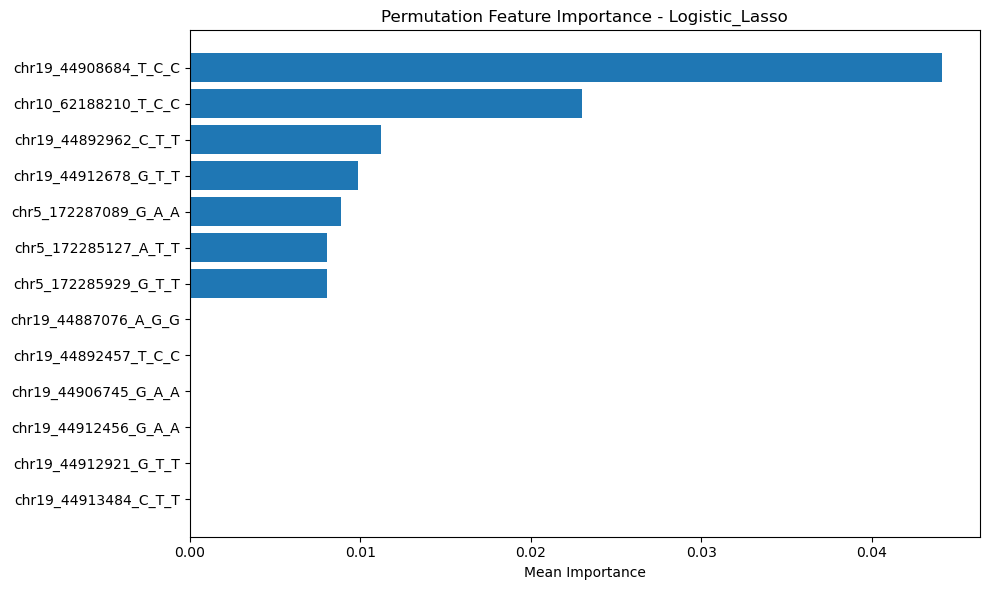


🔎 Evaluating Logistic_Ridge with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6630 ± 0.0162
📊 Logistic_Ridge - Train AUC: 0.6739 | Test AUC: 0.6626


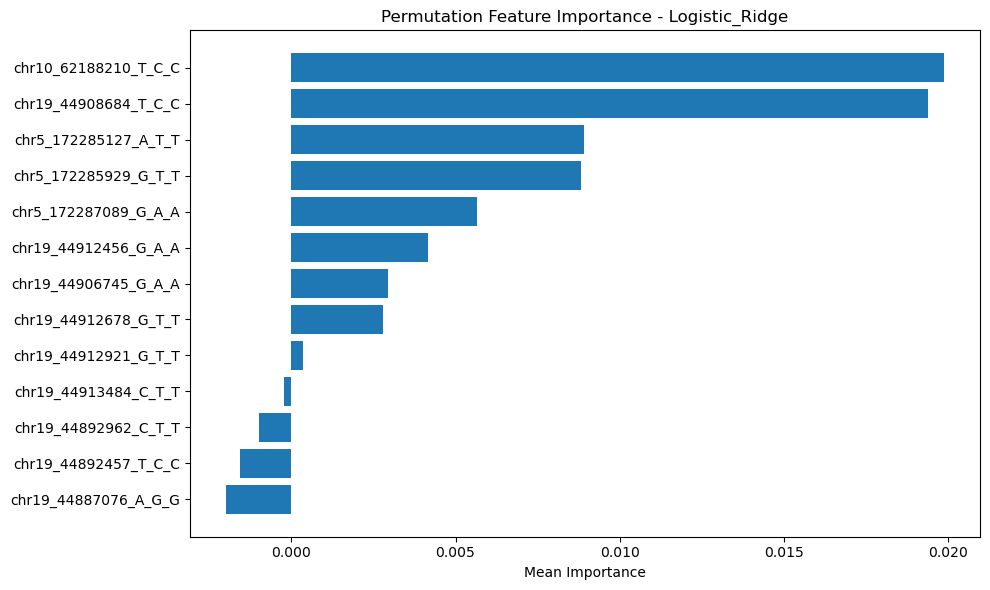


🔎 Evaluating Logistic_ElasticNet with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6613 ± 0.0137
📊 Logistic_ElasticNet - Train AUC: 0.6731 | Test AUC: 0.6618


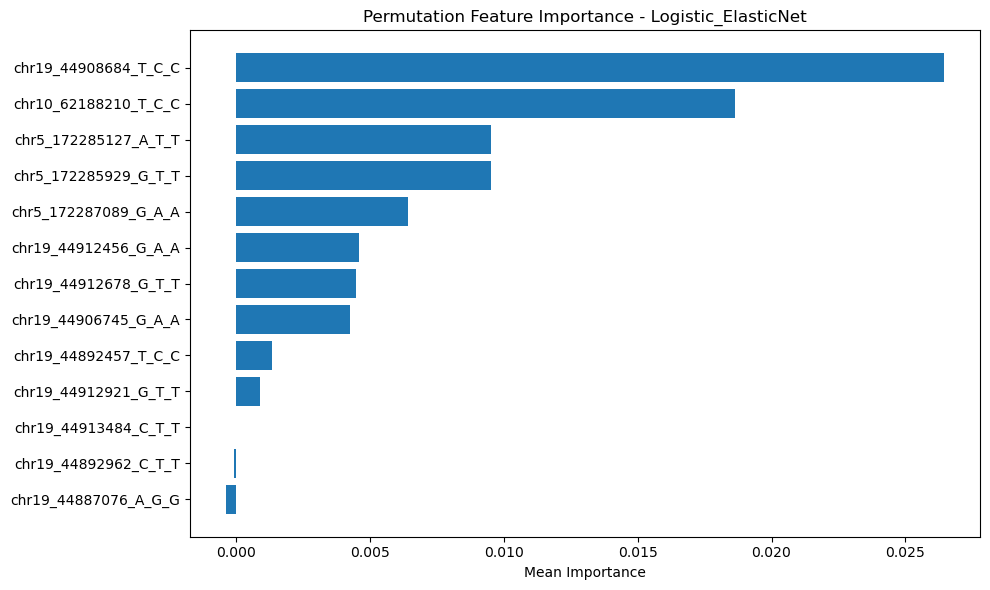


🔎 Evaluating XGBoost with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6603 ± 0.0111
📊 XGBoost - Train AUC: 0.6919 | Test AUC: 0.6586


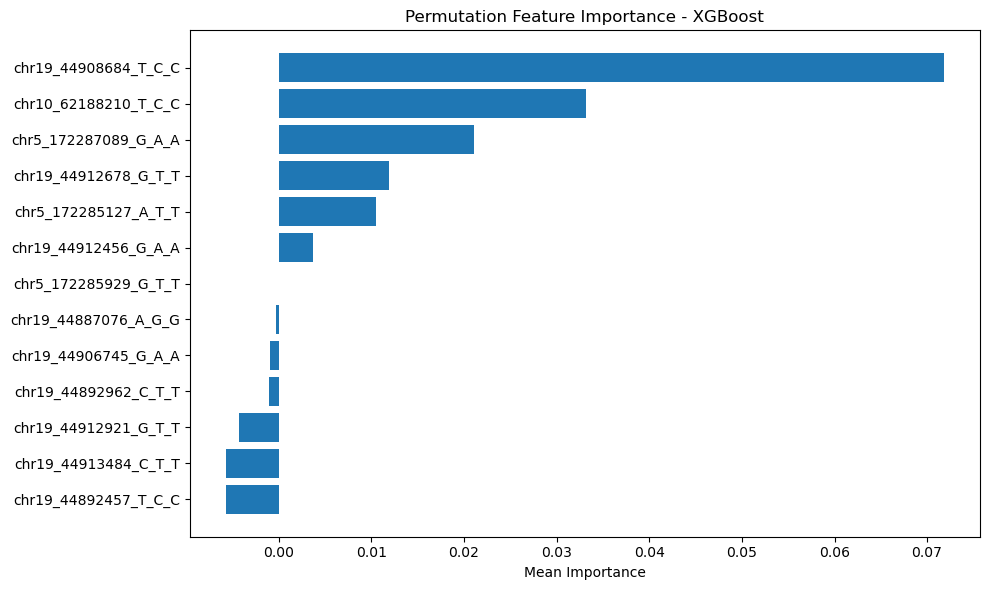


🔎 Evaluating LightGBM with best hyperparameters...
[LightGBM] [Info] Number of positive: 356, number of negative: 340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 696, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511494 -> initscore=0.045985
[LightGBM] [Info] Start training from score 0.045985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

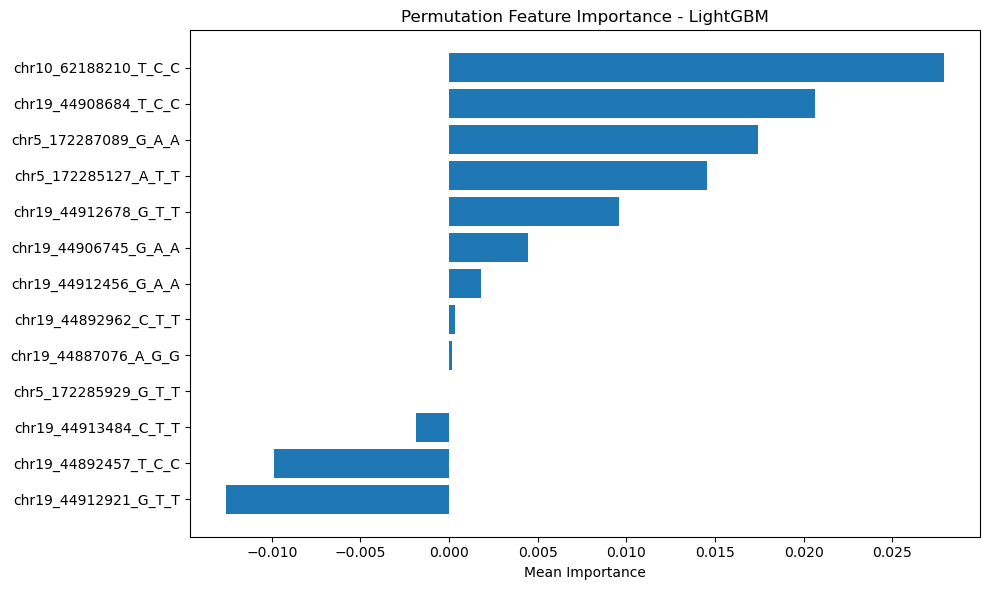


🔎 Evaluating CatBoost with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6560 ± 0.0068
📊 CatBoost - Train AUC: 0.6879 | Test AUC: 0.6444


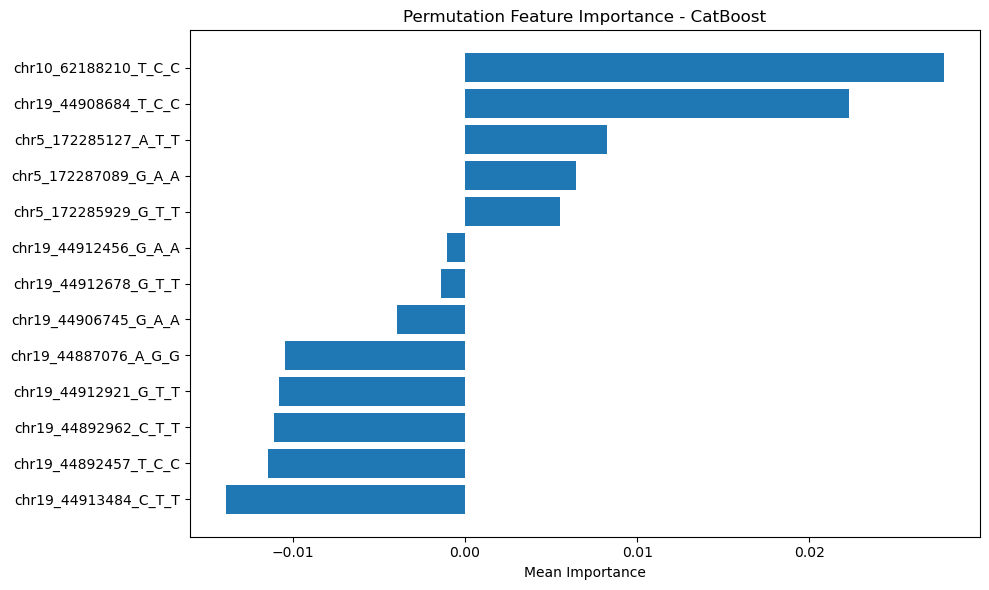


🔎 Evaluating NeuralNetwork with best hyperparameters...
✅ Mean ROC-AUC (CV): 0.6618 ± 0.0053
📊 NeuralNetwork - Train AUC: 0.6919 | Test AUC: 0.6614


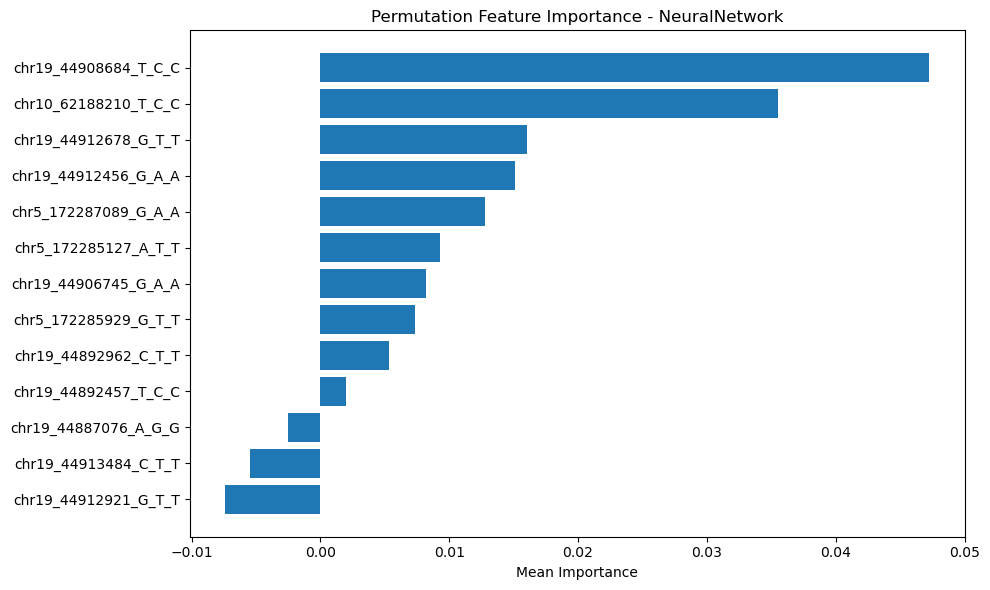

In [24]:
# === Cross-validation setup === #
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store best models from the hyperparameter tuning step
best_models = {}

# === Evaluate models using the optimized parameters === #
for name, config in param_distributions.items():
    print(f"\n🔎 Evaluating {name} with best hyperparameters...")

    # Get the best model from RandomizedSearchCV
    random_search = RandomizedSearchCV(
        config["model"], config["params"], cv=cv, scoring='roc_auc', n_iter=10, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)  # Tune on training data only
    best_model = random_search.best_estimator_

    # Store the best model
    best_models[name] = best_model

    # Cross-validated ROC-AUC
    auc_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"✅ Mean ROC-AUC (CV): {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

    # Predict probabilities using the best model
    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict_proba(X_test)[:, 1]

    # AUC scores
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    print(f"📊 {name} - Train AUC: {auc_train:.4f} | Test AUC: {auc_test:.4f}")

    # === Permutation Feature Importance (PFI) === #
    result = permutation_importance(best_model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1)

    # Save feature importance results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    }).sort_values(by='Importance', ascending=False)
    importance_df.to_csv(f"../output/tables/PFI_{name}_ADSP.csv", index=False)

    # === Plot top 20 important features === #
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
    plt.xlabel('Mean Importance')
    plt.title(f'Permutation Feature Importance - {name}')
    plt.tight_layout()
    plt.savefig(f"../output/plots/PFI_{name}_CHsumStat_PRADIdosage_recessive_ADSP.png")
    plt.show()


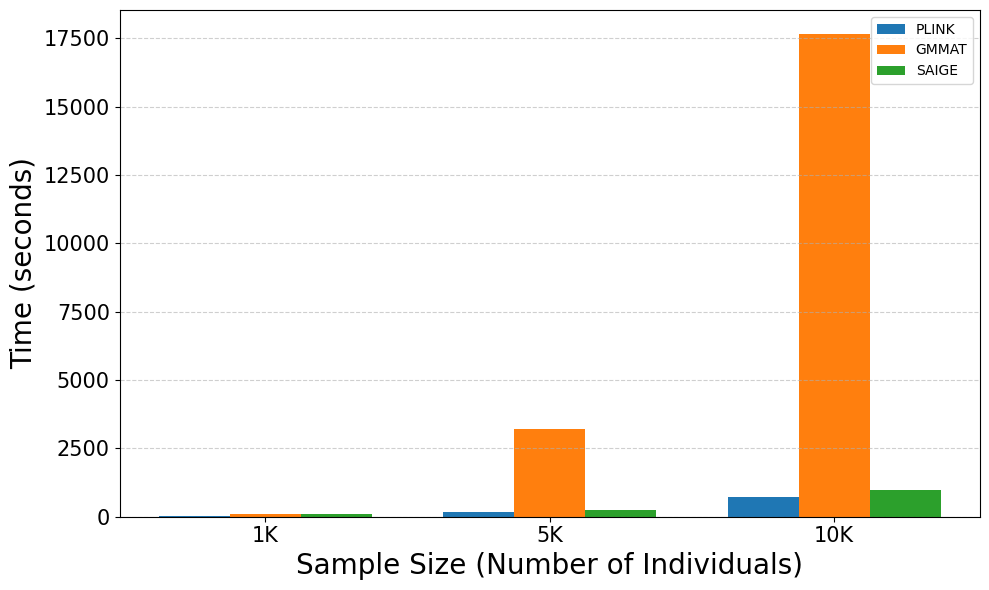

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
sample_sizes = ['1K', '5K', '10K']
plink_times = [19, 181, 727]
gmmat_times = [108, 3218, 17652]
saige_times = [103, 247, 989]

# Bar width and position
x = np.arange(len(sample_sizes))
bar_width = 0.25

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, plink_times, width=bar_width, label='PLINK')
plt.bar(x, gmmat_times, width=bar_width, label='GMMAT')
plt.bar(x + bar_width, saige_times, width=bar_width, label='SAIGE')

# Labels and formatting
plt.xlabel('Sample Size (Number of Individuals)',fontsize=20)
plt.ylabel('Time (seconds)',fontsize=20)
#plt.title('Benchmark of GWAS Tools by Sample Size',fontsize=20)
plt.xticks(x, sample_sizes,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


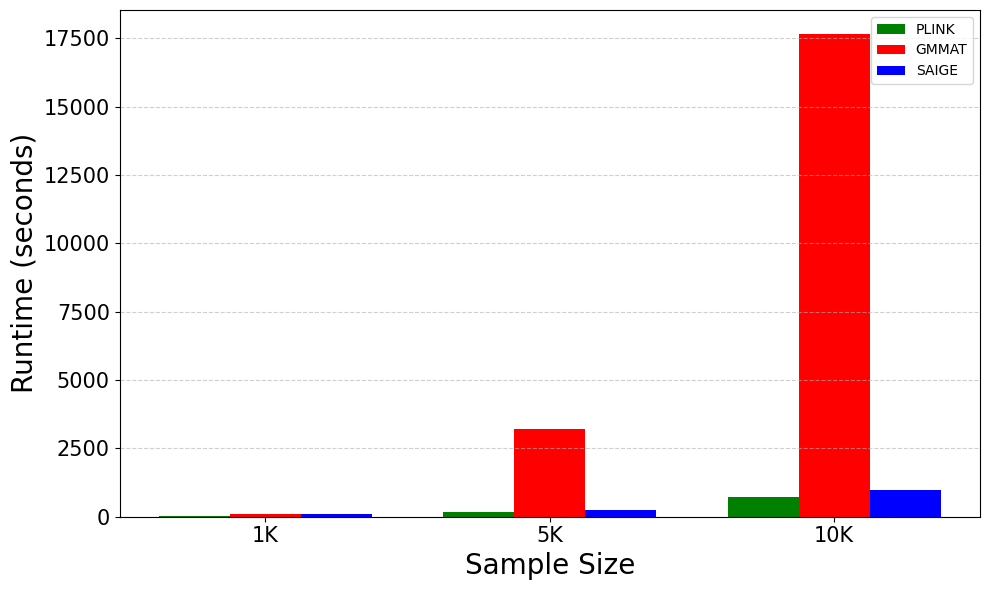

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Sample sizes and corresponding runtimes (in seconds)
sample_sizes = ['1K', '5K', '10K']
plink_times = [19, 181, 727]
gmmat_times = [108, 3218, 17652]
saige_times = [103, 247, 989]

# Bar width and positions
bar_width = 0.25
x = np.arange(len(sample_sizes))

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, plink_times, width=bar_width, color='green', label='PLINK')
plt.bar(x, gmmat_times, width=bar_width, color='red', label='GMMAT')
plt.bar(x + bar_width, saige_times, width=bar_width, color='blue', label='SAIGE')

# Labeling
plt.xlabel('Sample Size', fontsize=20)
plt.ylabel('Runtime (seconds)', fontsize=20)
#plt.title('GWAS Tool Runtime Benchmark', fontsize=14)
plt.xticks(x, sample_sizes,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.show()
